# Create a polynomial chaos metamodel by integration on the cantilever beam


In this example, we create a polynomial chaos metamodel by integration on the
cantilever beam example.
We choose to evaluate the coefficients of the chaos decomposition by
integration using various kinds of design of experiment:
- Gauss product
- Monte-Carlo sampling
- Latin hypercube sampling
- Quasi Monte Carlo with a Sobol' sequence

We will compare the results obtained on each design.

In [1]:
from openturns.usecases import cantilever_beam
import openturns as ot
import openturns.viewer as otv
import numpy as np

ot.Log.Show(ot.Log.NONE)

In [2]:
# %%
# We first load the model from the usecases module :
cb = cantilever_beam.CantileverBeam()

# %%
# In this example we consider all marginals independent. They are defined in the `CantileverBeam` data class as well as an independent distribution:
dist_E = cb.E
dist_F = cb.F
dist_L = cb.L
dist_I = cb.II
distribution = cb.independentDistribution
distribution

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 3.5, a = 6.5e+10, b = 7.5e+10)"
1,F,"LogNormal(muLog = 5.69881, sigmaLog = 0.0997513, gamma = 0)"
2,L,"Uniform(a = 2.5, b = 2.6)"
3,I,"Beta(alpha = 2.5, beta = 4, a = 1.3e-07, b = 1.7e-07)"


In [3]:

# %%
# We load the model
dim_input = cb.dim  # dimension of the input
dim_output = 1  # dimension of the output
g = cb.model

# %%
# Create a polynomial chaos decomposition
# ---------------------------------------

# %%
# We create the multivariate polynomial basis by tensorization of the
# univariate polynomials and the default linear enumerate rule.
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

# %%
# We see that the number of polynomials is equal to 126.
# This will lead to the computation of 126 coefficients.
totalDegree = 5
enum_func = multivariateBasis.getEnumerateFunction()
P = enum_func.getBasisSizeFromTotalDegree(totalDegree)
print("P = ", P)

# %%
# We select the `FixedStrategy` truncation rule, which corresponds to using
# the first `P` polynomials of the polynomial basis.
# In this case, we select `P` using the `getStrataCumulatedCardinal` method,
# so that all polynomials with total degree lower or equal to 5 are used.
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)

#
# We begin by getting the standard measure associated with the multivariate polynomial basis. We see that the range of the `Beta` distribution has been standardized into the [-1,1] interval. This is the same for the `Uniform` distribution and the second `Beta` distribution.
measure = multivariateBasis.getMeasure()
measure

P =  126


class=ComposedDistribution name=ComposedDistribution dimension=4 copula=class=IndependentCopula name=IndependentCopula dimension=4 marginal[0]=class=Beta name=Beta dimension=1 alpha=0.9 beta=3.5 a=-1 b=1 marginal[1]=class=LogNormal name=LogNormal dimension=1 muLog=5.69881 sigmaLog=0.0997513 gamma=0 marginal[2]=class=Uniform name=Uniform dimension=1 a=-1 b=1 marginal[3]=class=Beta name=Beta dimension=1 alpha=2.5 beta=4 a=-1 b=1

In [4]:
def computeQsquaredFromExperiment(experiment, distribution, n_valid):
    projectionStrategy = ot.IntegrationStrategy(experiment)
    inputSample, weights = experiment.generateWithWeights()
    outputSample = g(inputSample)
    algo = ot.FunctionalChaosAlgorithm(
        inputSample, weights, outputSample, distribution, adaptiveStrategy, projectionStrategy
    )
    algo.run()
    result = algo.getResult()
    metamodel = result.getMetaModel()
    X_test = distribution.getSample(n_valid)
    Y_test = g(X_test)
    val = ot.MetaModelValidation(X_test, Y_test, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    Q2 = max(Q2, 0.0)
    return Q2

In [5]:
experiment = ot.MonteCarloExperiment(distribution, 40000)
n_valid = 40000
computeQsquaredFromExperiment(experiment, distribution, n_valid)


0.7969052829518016

In [6]:
def computeQ2ArrayFromExperiment(
    experiment,
    distribution,
    number_of_repetitions,
    minimum_sample_size_exponent,
    maximum_sample_size_exponent,
    number_of_sample_sizes,
    n_valid,
):
    sample_size_array = np.logspace(
        minimum_sample_size_exponent,
        maximum_sample_size_exponent,
        number_of_sample_sizes,
    )
    sample_size_array = [int(sample_size) for sample_size in sample_size_array]
    number_of_sample_sizes = len(sample_size_array)
    total_experiments = number_of_sample_sizes * number_of_repetitions
    q2_sample = ot.Sample(total_experiments, 2)
    index = 0
    for i in range(number_of_sample_sizes):
        sample_size = sample_size_array[i]
        experiment.setSize(sample_size)
        for j in range(number_of_repetitions):
            q2_sample[index, 0] = sample_size
            q2Score = computeQsquaredFromExperiment(experiment, distribution, n_valid)
            q2_sample[index, 1] = q2Score
            index += 1
    return q2_sample

In [7]:
n_valid = 1000

# Monte-Carlo
minimum_sample_size_exponent = 2
maximum_sample_size_exponent = 5
number_of_sample_sizes = 10
number_of_repetitions = 5
experiment = ot.MonteCarloExperiment()
experiment.setDistribution(distribution)
q2_sample_MC = computeQ2ArrayFromExperiment(
    experiment,
    distribution,
    number_of_repetitions,
    minimum_sample_size_exponent,
    maximum_sample_size_exponent,
    number_of_sample_sizes,
    n_valid,
)


In [8]:
experiment = ot.LHSExperiment(distribution, 215)
n_valid = 40000
computeQsquaredFromExperiment(experiment, distribution, n_valid)


0.0

In [9]:
# LHS
minimum_sample_size_exponent = 2
maximum_sample_size_exponent = 5
number_of_sample_sizes = 10
number_of_repetitions = 5
experiment = ot.LHSExperiment()
experiment.setAlwaysShuffle(True)  # See https://github.com/openturns/openturns/issues/2431
experiment.setDistribution(distribution)
q2_sample_LHS = computeQ2ArrayFromExperiment(
    experiment,
    distribution,
    number_of_repetitions,
    minimum_sample_size_exponent,
    maximum_sample_size_exponent,
    number_of_sample_sizes,
    n_valid,
)


In [10]:
# Sobol'
minimum_sample_size_exponent = 2
maximum_sample_size_exponent = 4
number_of_sample_sizes = 10
number_of_repetitions = 5
sequence = ot.SobolSequence()
experiment = ot.LowDiscrepancyExperiment(sequence, distribution, 10)
q2_sample_Sobol = computeQ2ArrayFromExperiment(
    experiment,
    distribution,
    number_of_repetitions,
    minimum_sample_size_exponent,
    maximum_sample_size_exponent,
    number_of_sample_sizes,
    n_valid,
)


In [11]:
# GaussProductExperiment
minimum_number_of_marginal_nodes = 2
maximum_number_of_marginal_nodes = 5
total_experiments = (
    maximum_number_of_marginal_nodes - minimum_number_of_marginal_nodes + 1
)
q2_sample_Gauss = ot.Sample(total_experiments, 2)
index = 0
for number_of_marginal_nodes in range(
    minimum_number_of_marginal_nodes, 1 + maximum_number_of_marginal_nodes
):
    marginalSizes = [number_of_marginal_nodes] * dim_input
    experiment = ot.GaussProductExperiment(distribution, marginalSizes)
    sample_size = experiment.getSize()
    q2_sample_Gauss[index, 0] = sample_size
    q2_sample_Gauss[index, 1] = computeQsquaredFromExperiment(experiment, distribution, n_valid)
    index += 1

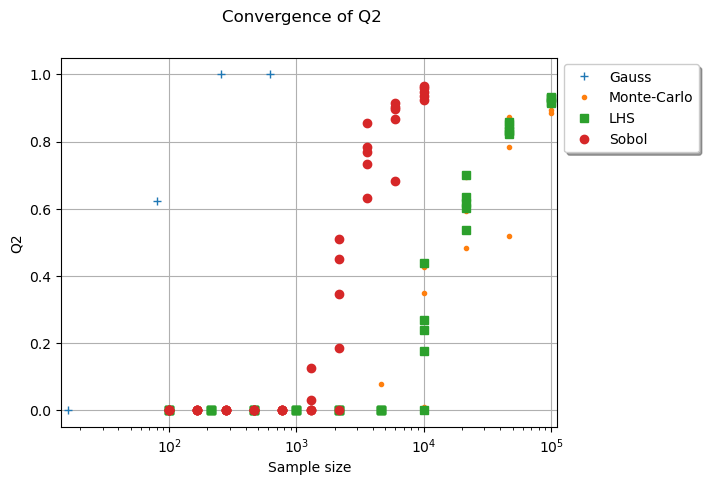

In [13]:
graph = ot.Graph("Convergence of Q2", "Sample size", "Q2", True)
# Gauss
cloud = ot.Cloud(q2_sample_Gauss)
cloud.setLegend("Gauss")
cloud.setPointStyle("plus")
graph.add(cloud)
# LHS
cloud = ot.Cloud(q2_sample_MC)
cloud.setLegend("Monte-Carlo")
cloud.setPointStyle("bullet")
graph.add(cloud)
# LHS
cloud = ot.Cloud(q2_sample_LHS)
cloud.setLegend("LHS")
cloud.setPointStyle("square")
graph.add(cloud)
# Sobol'
cloud = ot.Cloud(q2_sample_Sobol)
cloud.setLegend("Sobol")
cloud.setPointStyle("circle")
graph.add(cloud)
graph.setLogScale(ot.GraphImplementation.LOGX)
graph.setLegendPosition("topleft")
graph.setColors(ot.Drawable().BuildDefaultPalette(4))
view = otv.View(graph, legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"})
view.getFigure().savefig("convergence-chaos-integration.pdf", bbox_inches="tight")